# 전력사용량 예측
 
##  - 팀: 코드빼!


### 1. 라이브러리 로드.

In [191]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
from datetime import datetime, date, timedelta
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# need to install to add more features.
# from workalendar.asia import SouthKorea
# import pendulum

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

%config InlineBackend.figure_format = 'retina' # 더 높은 해상도로 출력한다.


# 2. 데이터 준비.

In [192]:

from google.colab import drive

if os.path.exists('/content/gdrive') == False :
    drive.mount('/content/gdrive')

# 데이터가 있는 위치.
data_path = '/content/gdrive/MyDrive/data/dacon_energy/'
#data_path = "./energy/"


In [196]:
train_data_path = join(data_path, 'train.csv')
test_data_path = join(data_path, 'test.csv')
submission_path = join(data_path, 'sample_submission.csv')
pickle_path = join(data_path, 'train.pic')

train = pd.read_csv(train_data_path, encoding="euc-kr")
test = pd.read_csv(test_data_path, encoding="euc-kr")
submission = pd.read_csv(submission_path, encoding="euc-kr")

# 건물번호(num)에 따라 일부데이터만 처리할 수 있도록 수정.
num_start = 1
num_end = 4

models = list()

# preprocessed된 데이터를 저장/로드함.
def save_train():
    train.to_pickle(pickle_path)

def load_train(df):
    return pd.read_pickle(pickle_path)

# TODO:
# model들을 저장.
def save_models():
    # TODO:
    # s = pickle.dumps(clf)
    pass

# model들을 로드함.
def load_models():
    # TODO:
    # clf2 = pickle.loads(s)
    pass


# 참고용 컬럼명 저장.
train_columns_name = train.columns.values
test_columns_name = test.columns.values

train_new_columns_name = ['num', 'date_time', 'power', 'temp', 'wind', 'humidity', 'rain', 'sunshine', 'coolequip', 'solar']
test_new_columns_name = ['num', 'date_time', 'temp', 'wind', 'humidity', 'rain', 'sunshine', 'coolequip', 'solar']

# 컬럼명을 쓰기편하도록 변경.
train.columns = train_new_columns_name
test.columns = test_new_columns_name

# pickle된 데이터가 있으면 로드.
if os.path.exists(pickle_path):
    train = load_train(train)
    print(train.head(2))


print(train.head())

   num      date_time     power  temp  wind  humidity  rain  sunshine  \
0    1  2020-06-01 00  8179.056  17.6   2.5      92.0   0.8       0.0   
1    1  2020-06-01 01  8135.640  17.7   2.9      91.0   0.3       0.0   
2    1  2020-06-01 02  8107.128  17.5   3.2      91.0   0.0       0.0   
3    1  2020-06-01 03  8048.808  17.1   3.2      91.0   0.0       0.0   
4    1  2020-06-01 04  8043.624  17.0   3.3      92.0   0.0       0.0   

   coolequip  solar  
0        0.0    0.0  
1        0.0    0.0  
2        0.0    0.0  
3        0.0    0.0  
4        0.0    0.0  


### 3. 전처리.

In [197]:
# 전처리. train과 submission를 합친 data에 대해서 일괄 처리함.

def check_null_columns(df):
    # data 컬럼이 결측치인지 확인합니다.
    for c in df.columns:
        print('컬럼: {} : 결측치: {}'.format(c, len(df.loc[pd.isnull(df[c]), c].values)))


# check_null_columns(train)

# 결측치 보간.
# TODO:
# submission date 보간필요


컬럼: num : 결측치: 0
컬럼: date_time : 결측치: 0
컬럼: power : 결측치: 0
컬럼: temp : 결측치: 0
컬럼: wind : 결측치: 0
컬럼: humidity : 결측치: 0
컬럼: rain : 결측치: 0
컬럼: sunshine : 결측치: 0
컬럼: coolequip : 결측치: 0
컬럼: solar : 결측치: 0


In [198]:
# 건물별 온도에 대하여 
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)


def dataframe_preprocess(df):

    # datetime object를 추가.
    df['date_o'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d')

    # df['year'] = df['date_o'].apply(lambda x : x.year)
    df['month'] = df['date_o'].apply(lambda x : x.month)
    df['day'] = df['date_o'].apply(lambda x : x.day)
    df['hour'] = df['date_o'].apply(lambda x : x.hour)

    # holidays정보 추가.
    # cal = SouthKorea()

    # df['holiday'] = df['date_o'].apply(cal.is_holiday).astype(int)
    # df['workingday'] = df['date_o'].apply(cal.is_working_day).astype(int)

    # 1:monday, 2:tuesday
    df['weekday'] = df['date_o'].apply(lambda x : x.weekday())
    df['weekend'] = df['date_o'].apply(lambda x : x.weekday() == 6 or x.weekday() == 7).astype(int)

    # first week: 1
    # df['weekno'] = df['date_o'].apply(lambda x : pendulum.datetime(x.year, x.month, x.day).week_of_month)
    
    ## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
    # df['sin_time'] = np.sin(2*np.pi*df.hour/24)
    # df['cos_time'] = np.cos(2*np.pi*df.hour/24)
    
    ## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
    # 불쾌지수
    # df['THI'] = 9/5*df['temp'] - 0.55*(1-df['humidity']/100)*(9/5*df['humidity']-26)+32

    """
    cdhs = np.array([])
    for num in range(1,61,1):
        temp = df[df['num'] == num]
        cdh = CDH(temp['temp'].values)
        cdhs = np.concatenate([cdhs, cdh])
    
    # CDH(Cooling Degree Hour)
    df['CDH'] = cdhs
    """

    # 1 or 0만 있는 컬럼이므로, 없으면 0으로 채워줌.
    df['coolequip'].fillna(0, inplace=True)
    df['solar'].fillna(0, inplace=True)

    del df['date_o']
    # del df['date_time']


# dataframe_preprocess(train)


# https://www.kma.go.kr/kma/biz/forecast05.jsp 참조
# 시간 범주 표현.
# 오전/오후 : 오전(00-12), 오후(12-24)
# 새벽/오전/오후/밤 : 새벽(00-06), 오전(06-12), 오후(12-18), 밤(18-24)
# 새벽(이른/늦은), 아침/오전/낮/늦은오후/저녁/늦은밤
# 00-03,03-06, 06-09, 09-12, 12-15, 15-18, 18-21, 21-24

# TODO:

# https://www.kma.go.kr/kma/biz/forecast05.jsp 참조
# 바람세기에 따른 분류
# 약간 강한 바람 : 4-9m/s 미만.
# 강한 바람 : 9-14m/s 미만.
# 매우 강한 바람 :
    # 주의보 : 14m/s 이상.
    # 경보 : 21m/s 이상.

# 강수/적설 분류
# 빗방울 : 0.1mm 미만.
# 약한비 : 1-3mm 미만.
# 보통비 : 3-15mm 미만
# 강한비 : 15-30mm 미만
# 매우강한비: 30mm 이상.


In [199]:
#https://dacon.io/competitions/official/235736/codeshare/2877?page=1&dtype=recent 참조.

def add_statistic_feature(df):
    #######################################
    ## 건물별, 요일별, 시간별 전력사용량 평균 넣어주기
    #######################################
    power_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour', 'weekday'], aggfunc = np.mean).reset_index()
    df['day_hour_mean'] = df.apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.hour == x['hour']) & (power_mean.weekday == x['weekday']) ,'power'].values[0], axis = 1)

    #######################################
    ## 건물별 시간별 전력사용량 평균 넣어주기
    #######################################
    power_hour_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.mean).reset_index()
    df['hour_mean'] = df.apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

    # #######################################
    # ## 건물별 시간별 전력사용량 표준편차 
    # #######################################
    power_hour_std = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.std).reset_index()
    df['hour_std'] = df.apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)


# static 컬럼 추가.
# add_statistic_feature(train)


In [200]:
# preprocessed된 데이터를 pickle함
save_train()

In [214]:
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num            122400 non-null  int64  
 1   date_time      122400 non-null  object 
 2   power          122400 non-null  float64
 3   temp           122400 non-null  float64
 4   wind           122400 non-null  float64
 5   humidity       122400 non-null  float64
 6   rain           122400 non-null  float64
 7   sunshine       122400 non-null  float64
 8   coolequip      122400 non-null  float64
 9   solar          122400 non-null  float64
 10  month          122400 non-null  int64  
 11  day            122400 non-null  int64  
 12  hour           122400 non-null  int64  
 13  weekday        122400 non-null  int64  
 14  weekend        122400 non-null  int64  
 15  day_hour_mean  122400 non-null  float64
 16  hour_mean      122400 non-null  float64
 17  hour_std       122400 non-nul

### 4. 시각화

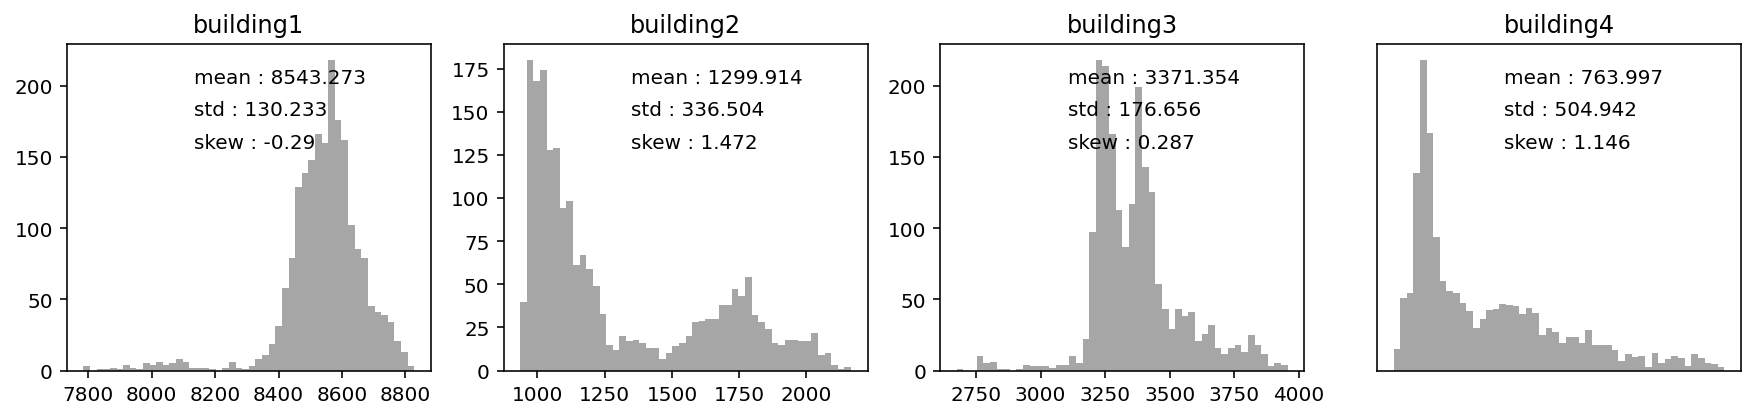

In [222]:
def show_building_power_histogram(start, end):
    
    plot_count = end - start + 1
    
    # plot을 아래로만 추가.
    col_count = 4
    row_count = int((plot_count + col_count - 1)/col_count)
    fig, axes = plt.subplots(nrows = row_count, ncols = col_count, figsize=(15, row_count*3))
    if plot_count > 1:
        axes = axes.flatten()
    else:
        axes = axes    

    for idx, num in enumerate(range(start, end + 1)):
        ax = axes[idx]
        energy = train.loc[train.num == num, 'power'].values
        mean = energy.mean().round(3)
        std = energy.std().round(3)
        skew = (3*(mean - np.median(energy))/energy.std()).round(3)

        if skew >= 1.5:
            ax.hist(energy, alpha = 0.7, bins = 50, color = 'red')
        elif skew <= -1.5:
            ax.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
        else:
            ax.hist(energy, alpha = 0.7, bins = 50, color = 'gray')

        ax.set_title(f'building{num}')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')
        plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
        plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
        plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)
    
    plt.show()


## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent 참조.
# 빌딩별 에너지 히스토그램 표시.
# show_building_power_histogram(num_start, num_end)
show_building_power_histogram(1, 4)

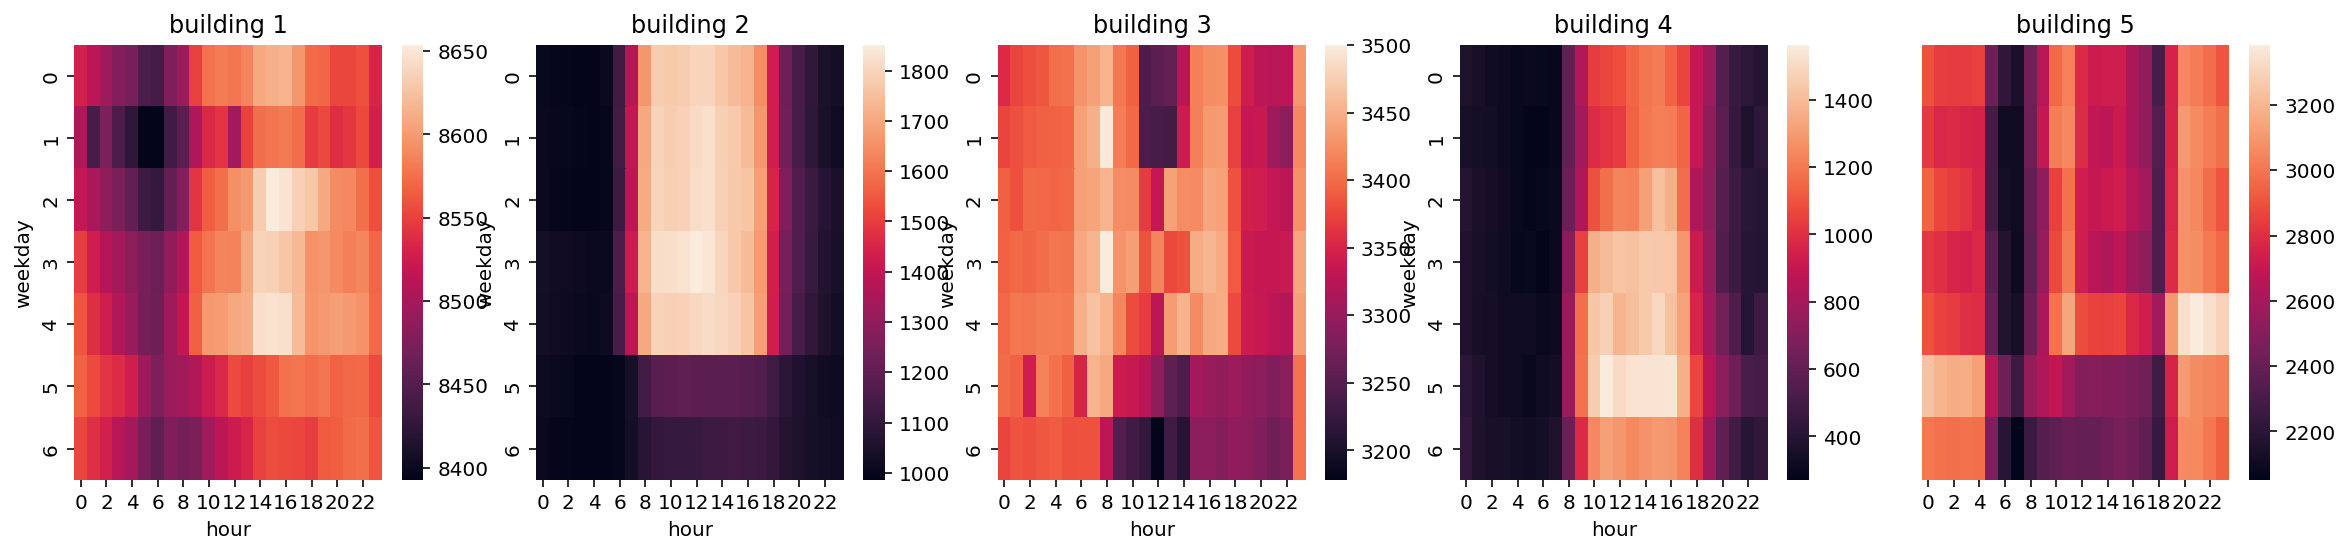

In [224]:

# energy usage of each building ~ weekday, hour
def show_heatmap(df, start, end):
    
    plot_count = end - start + 1
    
    # plot을 아래로만 추가.
    col_count = 5
    row_count = int((plot_count + col_count - 1)/col_count)    
    fig, axes = plt.subplots(nrows = row_count, ncols = col_count, figsize=(20, row_count*4))
    axes = axes.flatten()
    
    for idx, num in enumerate(range(start, end + 1)):
        ax = axes[idx]
        temp_df = df[df.num == num]
        temp_df = temp_df.groupby(['weekday', 'hour'])['power'].mean().reset_index()
        temp_df = temp_df.pivot('weekday', 'hour', 'power')
        
        sns.heatmap(temp_df, ax=ax)
        ax.set_title(f'building {num}')
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([])


# 빌딩별/일별/시간별 에너지 heatmap 표시.
# show_heatmap(train, num_start, num_end)
show_heatmap(train, 1, 5)

### 5. 모델링.

5.1 오차 확인.

In [202]:
# log여부를 반영한 rmse
def rmse(y_test, y_pred, logged=False):
    if logged:
        return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    else:
        return np.sqrt(mean_squared_error(y_test, y_pred))


# Define SMAPE loss function
# 0이나 근접한 데이터가 있는 경우 MAPE보다 적합함. 
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100


5.2 하이퍼 파라메타 검색.

In [69]:
#Grid Search로 최적의 파라메타 찾기.
## gridsearchCV for best model : 대략 1시간 소요

from sklearn.model_selection import PredefinedSplit, GridSearchCV

def grid_search():
    param_grid = {
        'n_estimators': [100, 500, 1000, 5000],
        'max_depth': [5, 10, 15],
        'learning_rate' : [0.001, 0.01, 0.1]
    }

    models.clear()

    for idx in range(60):
        model = LGBMRegressor(learning_rate=0.1, max_depth=20, n_estimators=5000, random_state=None)
        models.append(model)

    result_list = list()

    for i in np.arange(4, 61):
        y = train.loc[train.num == i, 'power']
        x = train.loc[train.num == i, ].iloc[:, 3:]
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=None, shuffle=False, test_size=168)
    
        model = models[i - 1]

        # GridSearchCV 모델로 초기화
        grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=20, verbose=False, n_jobs=-1)
        
        # 모델 fitting
        grid_model.fit(X_train, y_train)

        # 결과값 저장
        params = grid_model.cv_results_['params']
        score = grid_model.cv_results_['mean_test_score']
        
        # 데이터 프레임 생성
        results = pd.DataFrame(params)
        results['num'] = i
        results['score'] = score
        
        # RMSLE 값 계산 후 정렬
        results['RMSLE'] = np.sqrt(-1 * results['score'])
        results = results.sort_values('RMSLE')

        result_list.append(results)
        print('train{} \n: {}\n\n'.format(i, results))


# grid_search()


5.3 모델 학습 및 오차 확인.

In [218]:
# building number를 입력받아 모델 train하고 결과를 리턴함.
def train_model_by_num(num):
    
    y = train.loc[train.num == num, 'power']
    x = train.loc[train.num == num, ].iloc[:, 3:]
    
    # y_train, y_test, X_train, X_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=None, shuffle=False, test_size=168)
    
    model = models[num - 1]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    pred = pd.Series(y_pred)
    
    sm = SMAPE(y_test, y_pred)
    
    return sm, y_pred


# building number 시작/끝 번호를 입력받아 모델 train하고 결과들을 리턴함.
def train_models(start, end):
    scores = []   # smape 값을 저장할 list
    preds = np.array([]) 
    
    for num in range(start, end+1):
        
        print(". ", end="")
        
        sm, pred = train_model_by_num(num)
        scores.append(sm)
        preds = np.append(preds, pd.Series(pred))
    
    print(". \n")

    return scores, preds



def plot_socres(scores, limit = 10, title="", filesave=False):
    plt.bar(np.arange(len(scores))+1, scores)
    plt.plot([1,60], [limit, limit], color = 'red')
    plt.title(title)
    if filesave:
        plt.savefig(join(data_path, title+".png"))



In [204]:
# 여러개의 데이터를 하나의 ax에 가로로 연결함.
def plot_series(ax, serieses, show=True):
    
    count = len(serieses)
    pos = 0
    
    for i in range(count):
        datas = serieses[i]
        length = len(datas)
        
        ax.scatter(np.arange(pos, pos + length), datas)
        pos += length

    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.tick_params(axis='both', which='minor', labelsize=4)
    
    if show:
        plt.show()



# 여러개의 num(빌딩) 데이터를 세로로 표시함.
def plot_serieses_by_num(start, end, preds):
    
    plot_count = end - start + 1
    
    # plot을 아래로만 추가.
    fig, axes = plt.subplots(plot_count, 1, figsize=(100, 3 * plot_count), sharex = True)
    if plot_count > 1:
        axes = axes.flatten()
    else:
        axes = [axes, ]
    
    for idx, num in enumerate(range(start, end + 1)):

        # train data는 num으로 구분.
        train_y = train.loc[train.num == num, 'power'].reset_index(drop = True)
        
        # prediction은 idx로 구분.
        test_y = preds[ (idx) * 168 : (idx+1)*168 ]
        
        datas = [train_y, test_y]
        plot_series(axes[idx], datas, show=False)
            
    plt.show()

In [205]:
# 전역 모델들을 생성함.

random_state= 100
models.clear()

# GridSearch로 얻은 모델 파라메타: learning_rate, max_depth, n_estimators 순서임.
lgbm_params = [[ 0.01,  5,  100],[ 0.05,  5,  100],[0.001, 10, 1000],[0.001,  5, 5000],[ 0.01,  5, 1000],[0.001,  5, 5000],[ 0.01,  5,  500],[0.001,  5, 5000],[0.001, 15, 1000],[ 0.01,  5,  500],
                [ 0.01,  5, 1000],[ 0.01,  5, 5000],[  0.1,  5,  100],[0.001,  5, 5000],[ 0.01,  5,  500],[ 0.01, 10,  500],[ 0.01,  5,  500],[ 0.01,  5,  500],[  0.1, 15, 5000],[ 0.01, 15, 5000],
                [ 0.01,  5, 1000],[ 0.01,  5,  500],[ 0.01,  5,  500],[0.001,  5, 5000],[  0.1, 10, 5000],[ 0.01,  5,  500],[ 0.01,  5,  500],[0.001,  5, 5000],[0.001,  5, 5000],[0.001,  5, 5000],
                [0.001, 10, 5000],[ 0.01,  5,  500],[0.001, 15, 5000],[0.001,  5, 5000],[ 0.01,  5,  500],[ 0.01,  5,  500],[ 0.01, 15,  500],[  0.1, 10,  100],[ 0.01,  5,  500],[ 0.01,  5, 1000],
                [  0.1,  5,  500],[  0.1, 10,  100],[0.001,  5, 5000],[  0.1, 10,  100],[ 0.01,  5,  500],[ 0.01,  5, 5000],[ 0.01, 10,  500],[ 0.01,  5,  500],[ 0.01, 10, 1000],[ 0.01, 15, 5000],
                [ 0.01,  5, 5000],[ 0.01,  5,  500],[ 0.01,  5,  500],[  0.1, 10,  100],[ 0.01,  5,  100],[0.001,  5, 5000],[ 0.01,  5,  500],[0.001,  5, 5000],[0.010,  5, 5000],[ 0.01,  5, 1000] ] 

for idx in range(60):
    model_param = lgbm_params[idx]
    model = LGBMRegressor(learning_rate=model_param[0], max_depth=model_param[1], n_estimators=model_param[2], random_state=random_state)
    # model = RandomForestRegressor(random_state=100)
    
    models.append(model)


In [221]:
train.head()

,num,date_time,power,temp,wind,humidity,rain,sunshine,coolequip,solar,month,day,hour,weekday,weekend,day_hour_mean,hour_mean,hour_std
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,0,8528.627077,8540.373176,118.793252
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,0,8513.723077,8517.174776,137.989738
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,0,8496.625846,8509.055718,122.381197
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,0,8480.076923,8493.313129,122.054777
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,0,8472.051692,8479.522165,124.472447


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 



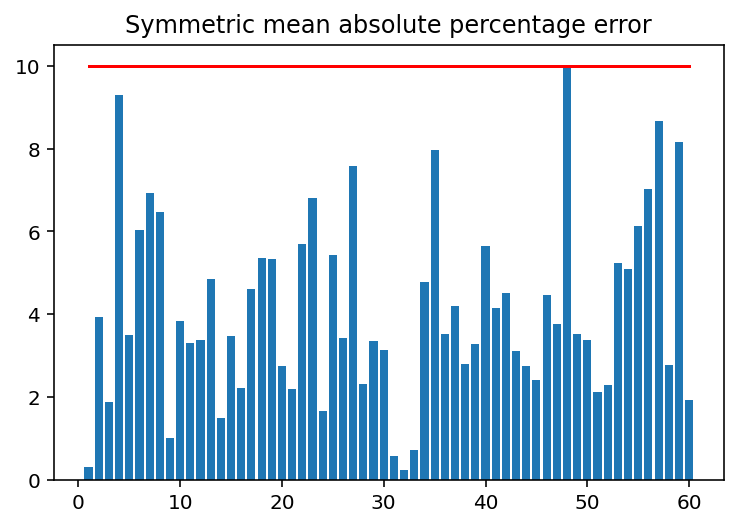

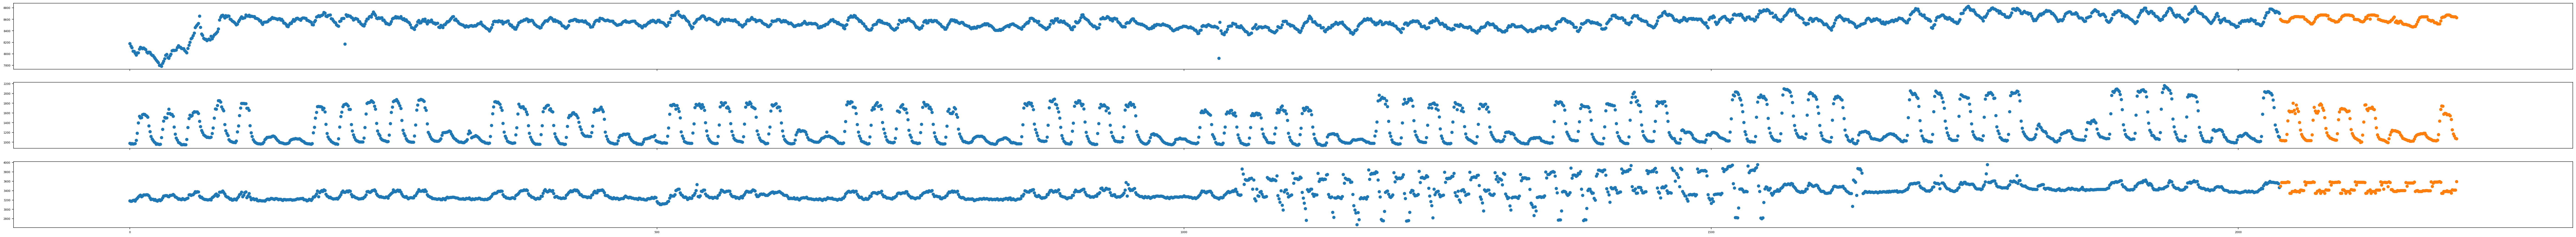

In [219]:
# 해당 모델을 학습시킴.

# 모델링 테스트 구간.
num_start = 1
num_end = 60

models.clear()

for idx in range(60):
    model_param = lgbm_params[idx]
    model = LGBMRegressor(learning_rate=model_param[0], max_depth=model_param[1], n_estimators=model_param[2], random_state=random_state)
    models.append(model)


scores, preds = train_models(num_start, num_end)

# 오차를 표시.
plot_socres(scores, 10, "Symmetric mean absolute percentage error", False)

# # 예측치와 결과치를 같이 표시.
preds = pd.Series(preds)

# plot_serieses_by_num(num_start, num_end, preds)
plot_serieses_by_num(1, 3, preds)


### 6. Submission

6.1 Submission 데이터 준비.

In [220]:
# pandas 내 선형보간 method 사용
for i in range(60):
    test.iloc[i*168:(i+1)*168, :]  = test.iloc[i*168:(i+1)*168, :].interpolate()

# test 데이터 전처리.
dataframe_preprocess(test)

# train에서 얻은 통계 값들을 test에 적용.
add_statistic_feature(test)

check_null_columns(test)

print(test.info())

컬럼: num : 결측치: 0
컬럼: date_time : 결측치: 0
컬럼: temp : 결측치: 0
컬럼: wind : 결측치: 0
컬럼: humidity : 결측치: 0
컬럼: rain : 결측치: 0
컬럼: sunshine : 결측치: 0
컬럼: coolequip : 결측치: 0
컬럼: solar : 결측치: 0
컬럼: month : 결측치: 0
컬럼: day : 결측치: 0
컬럼: hour : 결측치: 0
컬럼: weekday : 결측치: 0
컬럼: weekend : 결측치: 0
컬럼: day_hour_mean : 결측치: 0
컬럼: hour_mean : 결측치: 0
컬럼: hour_std : 결측치: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num            10080 non-null  int64  
 1   date_time      10080 non-null  object 
 2   temp           10080 non-null  float64
 3   wind           10080 non-null  float64
 4   humidity       10080 non-null  float64
 5   rain           10080 non-null  float64
 6   sunshine       10080 non-null  float64
 7   coolequip      10080 non-null  float64
 8   solar          10080 non-null  float64
 9   month          10080 non-null  int64  
 10  day       

6.2 Submission 제출.

In [213]:

preds = pd.Series()

# num별 predict를 진행.
for idx, num in enumerate(range(1, 61)):
    temp_df = test[test.num == num].iloc[:, 2:]
    y_pred = models[idx].predict(temp_df)
    preds = np.append(preds, pd.Series(y_pred))


submission = pd.read_csv(submission_path)
submission['answer'] = preds
    
#제출
submission.to_csv(data_path + join('energy_submission.csv'), index=False)
